In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools


def visualize_top_k_accuracy(accs):
    colors = itertools.cycle(['b', 'g', 'c', 'm', 'y', 'k'])
    max_x = max([max(k for k, _ in acc) for acc, _ in accs])
    for acc, name in accs:
        k, accuracy = zip(*acc)
        accuracy_percentage = [a * 100 for a in accuracy]  # Convert to percentage

        plt.plot(k, accuracy_percentage, color=next(colors))
        plt.xlabel('k')
        plt.ylabel('Top-k Accuracy (%)')
        plt.title('Top-k Accuracy')
        
    # Add a horizontal red dashed line at 100%
    plt.axhline(y=100, color='r', linestyle='--', label='100% Accuracy')

    plt.xticks(range(1, max_x + 1))
    # Show the legend
    plt.legend([name for _, name in accs])

    # Display the plot
    # plt.grid(True)
    plt.show()


def topk_accuracy(df, max_k=100):
    temp = -1
    k_acc = []
    for k in range(1, max_k + 1):
        top_k_conditions = [(df[f'top{rank}_text'] == df['answer_text']) for rank in range(1, k + 1)]
        top_k_accuracy = (df['correct'] & pd.concat(top_k_conditions, axis=1).any(axis=1)).mean()
        if top_k_accuracy != temp:
            k_acc.append((k, top_k_accuracy))
            temp = top_k_accuracy
        if top_k_accuracy == 1.0:
            break
    else:
        # 루프가 100%에 도달하지 못했을 경우 마지막 accuracy
        k_acc.append((k, top_k_accuracy))
        
    return k_acc

        
def topk_accuracy_fixed(df, topk=[1, 2, 3, 5, 10]):
    max_topk=(len(df.columns) - 3) // 2
    k_acc = []
    for k in range(1, max_topk + 1):
        # 각 k에 대해 모든 row에 대해 top_k 조건을 계산
        top_k_conditions = [(df[f'top{rank}_text'] == df['answer_text']) for rank in range(1, k + 1)]
        top_k_accuracy = (df['correct'] & pd.concat(top_k_conditions, axis=1).any(axis=1)).mean()

        # topk 리스트에 있는 값이 나오면 k_acc에 추가
        if k in topk:
            k_acc.append((k, top_k_accuracy))

        # top_k_accuracy가 1.0이면 k_acc에 추가하고 루프 종료
        if top_k_accuracy == 1.0:
            k_acc.append((k, top_k_accuracy))
            break

    return k_acc


def update_correct_column(df, k):
    # correct 열을 업데이트할 새로운 리스트를 만듦
    df = df.copy()
    updated_correct = []
    
    for idx, row in df.iterrows():
        found_correct = False
        
        # top-k 범위 내에서 answer_text와 일치하는지 확인
        for rank in range(1, k + 1):
            if row[f'top{rank}_text'] == row['answer_text']:
                found_correct = True
                break
        
        # 맞춘 경우 'correct', 아니면 'false' 추가
        if found_correct:
            updated_correct.append('correct')
        else:
            updated_correct.append('false')
    
    # correct 열 업데이트
    df['correct'] = updated_correct
    df_false = df[df['correct'] == 'false']
    
    return df_false


def print_false_answers(df, print_k=5):
    for idx, row in df.iterrows():
        print(f"query: {row['query']}")
        print(f"answer: {row['answer_text']}")
        print()
        for k in range(1, print_k + 1):
            print(f"top {k}: {row[f'top{k}_text'][:200]}")        
        print()
        print()

In [15]:
e5_mistral_wiki_raw_top_100 = pd.read_csv('../data/experiments/e5-mistral_wiki-raw_top-100.csv')
mul_e5_max_wiki_raw_top_100 = pd.read_csv('../data/experiments/multilang-e5_max_wiki-raw_top-100.csv')
mul_e5_mean_wiki_raw_top_100 = pd.read_csv('../data/experiments/multilang-e5_mean_wiki-raw_top-100.csv')
koe5_mean_wiki_model_top_100 = pd.read_csv('../data/experiments/KoE5_mean_wiki-model_top-100.csv')
koe5_max_wiki_raw_top_100 = pd.read_csv('../data/experiments/KoE5_max_wiki-raw_top-100.csv')

In [17]:
koe5_mean_wiki_model_top_all = pd.read_csv('../data/experiments/KoE5_mean_wiki-model_top-all.csv')

In [18]:
# calculate_top_k_accuracy(df, max_k=10)
k_acc = topk_accuracy_fixed(koe5_mean_wiki_model_top_all, topk=[1,2,3,5,10,15,20,25,30,35])
for k, acc in k_acc:
    print(f"Top {k} Accuracy: {acc * 100:.2f} %")

Top 1 Accuracy: 0.00 %
Top 2 Accuracy: 0.00 %
Top 3 Accuracy: 0.00 %
Top 5 Accuracy: 0.00 %
Top 10 Accuracy: 0.00 %
Top 15 Accuracy: 0.00 %
Top 20 Accuracy: 0.00 %
Top 25 Accuracy: 0.00 %
Top 30 Accuracy: 0.00 %
Top 35 Accuracy: 0.00 %


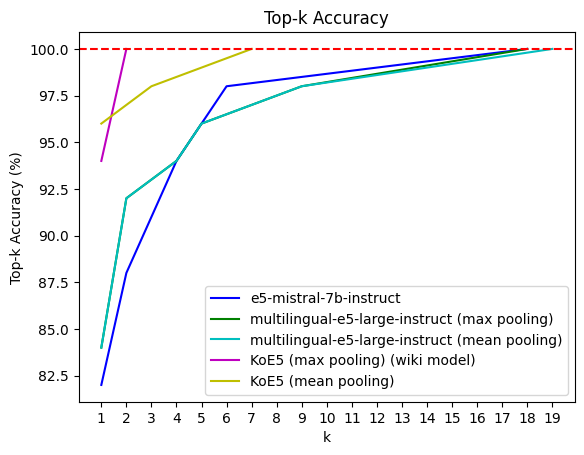

In [14]:
accs = [(topk_accuracy(e5_mistral_wiki_raw_top_100), 'e5-mistral-7b-instruct'),
        (topk_accuracy(mul_e5_max_wiki_raw_top_100), 'multilingual-e5-large-instruct (max pooling)'),
        (topk_accuracy(mul_e5_mean_wiki_raw_top_100), 'multilingual-e5-large-instruct (mean pooling)'),
        (topk_accuracy(koe5_mean_wiki_raw_top_100), 'KoE5 (max pooling) (wiki model)'),
        (topk_accuracy(koe5_max_wiki_raw_top_100), 'KoE5 (mean pooling)'),
        ]
visualize_top_k_accuracy(accs)

In [19]:
koe5_mean_wiki_model_top_all.head(5)

,query,answer_text,correct,top1_text,top1_score,top2_text,top2_score,top3_text,top3_score,top4_text,...,top96_text,top96_score,top97_text,top97_score,top98_text,top98_score,top99_text,top99_score,top100_text,top100_score
0,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,False,미국의 대외 관계 미국의 외교정책의 수립과 이행에 대한 주된 책임을 대통령이 지게 ...,51.651680,"미국의 헌법 제2조는 행정 기관으로서 대통령부를 언급했고, 대통령의 선출 방법, 자...",50.203260,대통령 지시 대통령 지시(Presidential directive)는 미국 대통령의...,47.555920,미국 대통령 계승순위 권한대행 역시 계승 자격이 있다. 2002년 세워진 싱크탱크 ...,...,캐나다의 정치 캐나다의 정치는 입헌군주제의 연방제로 강한 민주주의 전통을 가진 의회...,29.311832,미국 국립공원관리청 국립공원국은 내무부 산하의 기관이다. 1916년 8월 25일에 ...,29.227406,"콜 오브 듀티: 고스트 가까운 미래인 2017년 7월 10일, 미국은 자국의 방어 ...",29.103846,"호조 호조(戶曹)는 고려와 조선의 행정기관이다. 육조의 하나로, 호구, 공납, 부사...",29.048882,"호조 호조(戶曹)는 고려와 조선의 행정기관이다. 육조의 하나로, 호구, 공납, 부사...",29.048882
1,현대적 인사조직관리의 시발점이 된 책은?,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,False,인사조직관리 '근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는...,73.091350,인사조직관리 근대적 경영이론 또는 고전적 경영이론의 등장은 프레더릭 테일러의 연구가...,70.026794,인사조직관리 인류 역사에서 무리를 지어 살기 시작하면서 조직이 시작되었다. 인류를 ...,67.442930,인사조직관리 과학적 관리(과학적 경영)은 프레더릭 윈즐로 테일러의 《과학적 경영의 ...,...,버니바 부시 제2차 세계 대전이 끝나기 직전 1945년 7월 부시는 1939년에 써...,31.859684,"수행공학 수행공학은 일반체제이론, 커뮤니케이션 이론, 그리고 응용심리학에 그 뿌리를...",31.843340,직무 만족 Hackman과 Oldham에 의해 만들어진 직무 특성 모델(Job ch...,31.837755,분석심리학에대한 두편의 에세이 분석 심리학에 대한 두 편의 에세이(Two Essay...,31.832706,Computers and Intractability: A Guide to the T...,31.817406
2,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,False,강희제 강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 ...,62.777447,강희제 강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 ...,62.777447,강희제는 본래 명나라 홍무제가 만들고 순치제가 바꾼 〈육유(六諭)〉를 확대한 〈성유...,59.213047,"강희제 강희제는 소년 시절부터 많은 학문을 배웠다. 그중에서도 유학, 즉 성리학을 ...",...,성수침 필적 표지에 '청송서(聽松書)'라고 쓰여진 이 서첩은 16세기 학자 청송(聽...,34.481450,"1772년(영조 48) 겨울에 지사(知事) 이제암(李齊嵒), 판서(判書) 심각(沈瑴...",34.428307,"김창제 그는 문필가로서 YMCA 회보인 청년지의 발행인, 주필을 비롯해서 개벽(開闢...",34.356230,1563년 2월 호군으로 재직 중 졸하였다. 저서로는 시와 글을 모은 《괘편당실기 ...,34.279700,강희제 강희제는 8살의 어린 나이에 즉위하였기 때문에 아직 친정은 할 수 없었다. ...,34.253520
3,11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",False,삼존불비상 삼존불비상(三尊佛碑像)은 현재 동국대학교에 있는 것으로 충청남도 공주시 ...,51.828148,"이 마애불은 얕은 부조기법과 토속화된 얼굴 표현, 평행밀집형의 옷주름 표현 등에서 ...",51.004036,"태안 동문리 마애삼존불입상 제작 연대는 자세하게 밝혀지지는 않았으나, 6세기 중엽 ...",49.475266,용인 문수산 마애보살상 암반 위에 부처를 새기면 마애불(磨崖佛) 또는 마애여래(磨崖...,...,안양 삼막사 마애삼존불 삼막사의 칠성각 내에 봉안된 마애불은 암벽을 얕게 파고 조성...,39.083340,용촛대는 조선 후기 사찰의 재의식 공간을 장엄하는 데 사용하였던 의식법구의 하나로 ...,39.083126,"함평 해보리 석불입상 전라남도 함평 군민회관 앞에 있는 불상으로, 원래는 함평군 해...",39.022110,금동미륵보살반가사유상 (국보 제118호) 1944년 평양시 평천리에서 병기창 공사를...,38.998737,화염이 활활 타오르는 듯한 이러한 화염보관(火焰寶冠)은 중국의 명(明)나라 때부터 ...,38.976242
4,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,False,울주 천전리 각석 주로 신라 초기부터 통일신라에 이르기까지 조각되었다. 선긋기로 그...,49.774025,명문 중의 간지인 기유(己酉)를 《해동금석원》이나 《조선금석총람》에서 '기축(己丑)...,48.642143,한 벌은 5매로 완전하며 다른 한 벌은 4매로 제3매가 없다. 묘지 각 매의 옆 마...,45.939934,"출토유물은 자기류, 기와류, 소형 청동탄생불, 금동나한상, 탄화된 사경편 등이 주를...",...,본 작품은 복장기문을 통해 광서(光緖) 18년(1892)에 금어 응륜(應崙)을 비롯...,36.139210,진주 의암 진주 의암 사적비 의암사적비는 임진왜란 2차 진주성전투 때 진주성이 함락...,36.120220,남원 양씨 종중 문서 일괄 남원 양씨 종중 문서 일괄(南原 楊氏 宗中 文書 一括)은...,36.095276,"고구려 평양성 석편 모두 27자를 7줄에 걸쳐 새겼는데, 현재의 성석편은 두 번째 ...",36.056652,함양 평촌리 신고당 신도비 및 부부 묘표 신도비는 경상남도 유형문화재 300호로 지...,36.051723
